# Lib

In [1]:
! pip install neptune-client

import os
import re
import torch
import random
import warnings
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from torch.nn import *
from torch.optim import *
from itertools import chain
from ast import literal_eval
import neptune.new as neptune
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModel, AutoConfig


warnings.simplefilter(action='ignore', category=FutureWarning)

     |████████████████████████████████| 315 kB 805 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 67 kB 3.6 MB/s             
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565172 sha256=52c64fbfc221391f2fa811ecb7a4124ba5f2ece123d7e75ca4eebd9e6f52a5b2
  Stored in directory: /root/.cache/pip/wheels/4f/ff/e6/2128c7fd2e85bd327f524d44b07922848c40e48de6e75baa7e
Successfully built neptune-client


# Config

In [2]:
CFG = dict(seed=1,
           fold=0,
           lr=1e-5,
           p_drop=.2,
           n_epochs=3,
           n_splits=5,
           batch_size=8,
           auto_break_n=3,
           max_length=310,
           mode_debug=False,
           optimizer='AdamW',
           path_save_model='model.pth',
           criterion='BCEWithLogitsLoss',
           model_name="roberta-large",
)
CFG

{'seed': 1,
 'fold': 0,
 'lr': 1e-05,
 'p_drop': 0.2,
 'n_epochs': 3,
 'n_splits': 5,
 'batch_size': 8,
 'auto_break_n': 3,
 'max_length': 310,
 'mode_debug': False,
 'optimizer': 'AdamW',
 'path_save_model': 'model.pth',
 'criterion': 'BCEWithLogitsLoss',
 'model_name': 'roberta-large'}

# Neptune

In [3]:
run = neptune.init(
    project="petr.square/NBME---Score-Clinical-Patient-Notes",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwMjlhMTk5NS04ODcwLTQ3MzgtYmVlYy0xZWNkM2NkZGQwMmYifQ==",
)

run['model/parameters'] = CFG

https://app.neptune.ai/petr.square/NBME---Score-Clinical-Patient-Notes/e/NBMES-109
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Data loading

In [4]:
train_merge = pd.read_csv("../input/split-folds-nbme-score-clinical/5_folds_data.csv")
print(f"Shape train_merge = {train_merge.shape}")
train_merge.sample(3)

Shape train_merge = (14300, 9)


,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,fold
8428,55601_516,5,55601,516,"['under stress', 'losing her job']","['419 431', '439 453']",Patient is a 26yo f presenting for 2 week foll...,Increased-stress,0
11899,82622_801,8,82622,801,['son recently died'],['236 253'],HOI: 67 y/o F c/o difficulty falling asleep an...,Son-died-3-weeks-ago,1
11965,82799_813,8,82799,813,[],[],HPI - 67 yo F c/o insomnia for 3 weeks. It sta...,Visual-hallucination-once,4


# Preprocessing

In [5]:
def process_feature_text(text):
    text = re.sub('I-year', '1-year', text)
    text = re.sub('-OR-', " or ", text)
    text = re.sub('-', ' ', text)
    return text

def clean_spaces(text):
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('\r', ' ', text)
    return text

In [6]:
train_merge['location'] = train_merge.location.apply(literal_eval)
train_merge['annotation'] = train_merge.annotation.apply(literal_eval)

train_merge["pn_history"] = train_merge["pn_history"].apply(lambda x: x.strip())
train_merge["feature_text"] = train_merge["feature_text"].apply(process_feature_text)
train_merge["feature_text"] = train_merge["feature_text"].apply(clean_spaces)
train_merge["pn_history"] = train_merge["pn_history"].apply(clean_spaces)

train_merge["feature_text"] = train_merge["feature_text"].apply(lambda x: x.lower())
train_merge["pn_history"] = train_merge["pn_history"].apply(lambda x: x.lower())

train_merge['annotation_length'] = train_merge['annotation'].apply(len)

# Train/Test

In [7]:
train = train_merge.query(f'fold != {CFG["fold"]}').reset_index(drop=True)
valid = train_merge.query(f'fold == {CFG["fold"]}').reset_index(drop=True)

# Data Generator

In [8]:
class Data_gen(Dataset):
    def __init__(self, df, transforms_input, tokenizer):
        self.pn_historys = df['pn_history']
        self.feature_text = df['feature_text']
        self.locations =  df['location']
        self.annotation_lengths = df['annotation_length']

        
        self.transforms_input = transforms_input        
        self.tokenizer = tokenizer
    
        
    def __len__(self):
        return len(self.pn_historys)

    def __getitem__(self, index):
                
        tokens = self.transforms_input(self.tokenizer,
                                  self.pn_historys[index],
                                  self.feature_text[index],
                                  self.annotation_lengths[index], 
                                  self.locations[index])
        
        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["label"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens.sequence_ids()).astype("float16")
        
        
        return {'X': {'input_ids': input_ids,
                      'attention_mask': attention_mask,
                      'token_type_ids': token_type_ids,
                      'offset_mapping': offset_mapping,
                      'sequence_ids': sequence_ids},
                'y': labels}

# Transform

In [9]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            to_return.append(list(map(int, loc.split())))
    return to_return


def transform(tokenizer, pn_historys, feature_text, annotation_length, location_list):
    out = tokenizer(
        feature_text,
        pn_historys,
        truncation='only_second',
        max_length=CFG['max_length'],
        padding='max_length',
        return_offsets_mapping=True,
        return_token_type_ids=True
    )
    

    
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(location_list)
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"], out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1
                break

    out["label"] = labels
    
    return out

# Tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained('../input/nbme-roberta-large/roberta-large/tokenizers')

# DataLoader

In [11]:
train_set = Data_gen(train, transform, tokenizer)
train_loader = DataLoader(train_set, batch_size=CFG['batch_size'], shuffle=True)

valid_set = Data_gen(valid, transform, tokenizer)
valid_loader = DataLoader(valid_set, batch_size=CFG['batch_size'], shuffle=False)

for loader in train_loader, valid_loader:
    assert next(iter(loader))['X']['input_ids'].shape == next(iter(loader))['y'].shape

# Change device

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Model

In [13]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        config = torch.load('../input/nbme-roberta-large/roberta-large/config.pth')
        self.bert = AutoModel.from_pretrained(CFG['model_name'], config=config) # BERT model
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(config.hidden_size, 1)

        
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,  token_type_ids=token_type_ids) # , token_type_ids=token_type_ids)
        
        logits = self.fc1(self.dropout(outputs[0])).squeeze(-1)
        
        return logits

In [14]:
model = CustomModel()

criterion = eval(CFG['criterion'])(reduction="none")
optimizer = eval(CFG['optimizer'])(model.parameters(), lr=CFG['lr'])

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Score

In [15]:
def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is np.nan or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

# Class Trainer

In [16]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, epochs, device, path_save_model='model.torch', auto_break_n=1000, run=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.history_loss = []
        self.history_acc = []
        self.history_loss_val = []
        self.history_acc_val = []
        self.history_pres = []
        self.history_recc = []
        self.history_f1 = []
        self.history_pres_val = []
        self.history_recc_val = []
        self.history_f1_val = []
        self.best_valid_score = 0
        self.device = device
        self.path_save_model = path_save_model
        self.auto_break_n = auto_break_n
        self.run = run
        
        self.no_improvement_epoch = 0

        self.model.to(self.device)

    def fit(self, train_loader, valid_loader=None):
        
        for epoch in range(self.epochs):

            self.model.train()
            
            preds = []
            offsets = []
            seq_ids = []
            train_loss = []
            valid_labels = []
            
            for batch in tqdm(train_loader):
                                
                input_ids = batch['X']['input_ids'].to(self.device)
                attention_mask = batch['X']['attention_mask'].to(self.device)
                token_type_ids = batch['X']['token_type_ids'].to(self.device)
                offset_mapping = batch['X']['offset_mapping'].to(self.device)
                sequence_ids = batch['X']['sequence_ids'].to(self.device)
                
                
                labels = batch['y'].to(self.device)

                logits = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).squeeze(-1)
                loss = self.criterion(logits, labels)

                loss = torch.masked_select(loss, labels > -1.0).mean()

                train_loss.append(loss.item() * input_ids.size(0))
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                
                preds.append(logits.detach().cpu().numpy())
                offsets.append(offset_mapping.cpu().numpy())
                seq_ids.append(sequence_ids.cpu().numpy())
                valid_labels.append(labels.detach().cpu().numpy())
                
                
            preds = np.concatenate(preds, axis=0)
            offsets = np.concatenate(offsets, axis=0)
            seq_ids = np.concatenate(seq_ids, axis=0)
            valid_labels = np.concatenate(valid_labels, axis=0)
            location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
            score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)
            
            self.history_pres.append(score['precision'])
            self.history_recc.append(score['recall'])
            self.history_f1.append(score['f1'])
        
            loss_score = sum(train_loss) / len(train_loss)
            self.history_loss.append(loss_score)
            
            print('=' * 100)
            print(f"\033[1;34m=> {epoch + 1} <= epoch")
            print(f'\033[1;31m Train Loss: {loss_score}, Score: {score}')
            print('- ' * 50)
            
            if self.run:
                self.run['train/epoch/loss'].log(self.history_loss[-1])
                self.run['train/epoch/precision'].log(self.history_pres[-1])
                self.run['train/epoch/recall'].log(self.history_recc[-1])
                self.run['train/epoch/f1'].log(self.history_f1[-1])
                
            if valid_loader:
                loss_score_val = self.test_score(valid_loader, "\033[1;36m Validation")
                
                self.history_loss_val.append(loss_score_val)
                
                if self.run:
                    self.run['valid/epoch/loss'].log(self.history_loss_val[-1])
                    self.run['valid/epoch/precision'].log(self.history_pres_val[-1])
                    self.run['valid/epoch/recall'].log(self.history_recc_val[-1])
                    self.run['valid/epoch/f1'].log(self.history_f1_val[-1])

                
                    
                if self.history_f1_val[-1] > self.best_valid_score:
                    self.no_improvement_epoch = 0
                    self.best_valid_score = self.history_f1_val[-1]
                    self.save_model(epoch + 1)
                else:  
                    self.no_improvement_epoch += 1
                

                print(f"no improvement_iter = {self.no_improvement_epoch}")
                if self.no_improvement_epoch == self.auto_break_n:
                    print('Auto_break !!!')
                    if self.run:
                        self.run.stop()
                    break
                
    def test_score(self, valid_loader, info=""):
        self.model.eval()
        
        preds = []
        offsets = []
        seq_ids = []
        valid_loss = []
        valid_labels = []
        
        for batch in tqdm(valid_loader):

            input_ids = batch['X']['input_ids'].to(self.device)
            attention_mask = batch['X']['attention_mask'].to(self.device)
            token_type_ids = batch['X']['token_type_ids'].to(self.device)
            offset_mapping = batch['X']['offset_mapping'].to(self.device)
            sequence_ids = batch['X']['sequence_ids'].to(self.device)
            
            labels = batch['y'].to(self.device)
            
            with torch.no_grad():
                
                logits = self.model(input_ids, attention_mask, token_type_ids)
                loss = self.criterion(logits, labels)
                loss = torch.masked_select(loss, labels > -1.0).mean()

                valid_loss.append(loss.item() * input_ids.size(0))


                preds.append(logits.cpu().numpy())
                offsets.append(offset_mapping.cpu().numpy())
                seq_ids.append(sequence_ids.cpu().numpy())
                valid_labels.append(labels.cpu().numpy())


        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
        score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)
        
        self.history_pres_val.append(score['precision'])
        self.history_recc_val.append(score['recall'])
        self.history_f1_val.append(score['f1'])
        
        loss_score = sum(valid_loss) / len(valid_loss)
        print(f'{info} Loss : {loss_score}, Score: {score}')

        return loss_score


    def save_model(self, n_epoch):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            CFG['path_save_model']
        )
        if self.run:
            self.run[f'model/saved_model'].upload(CFG['path_save_model'])

# Fit

In [17]:
mod = Trainer(model, criterion, optimizer, CFG['n_epochs'], device, CFG['path_save_model'], CFG['auto_break_n'], run=run)

In [18]:
mod.fit(train_loader, valid_loader)

100%|██████████| 1430/1430 [21:05<00:00,  1.13it/s]


=> 1 <= epoch
 Train Loss: 0.2134878541038823, Score: {'Accuracy': 0.9903707416742434, 'precision': 0.6886047688267466, 'recall': 0.6269733907587911, 'f1': 0.6563454457772301}
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 358/358 [01:44<00:00,  3.44it/s]


 Validation Loss : 0.10240734899748663, Score: {'Accuracy': 0.9941279636743009, 'precision': 0.7808506068091504, 'recall': 0.8375910832061289, 'f1': 0.8082262210796914}
no improvement_iter = 0


100%|██████████| 1430/1430 [21:07<00:00,  1.13it/s]


=> 2 <= epoch
 Train Loss: 0.0912175336543147, Score: {'Accuracy': 0.9944909634813585, 'precision': 0.7885587607126443, 'recall': 0.8531336604342008, 'f1': 0.8195762048097558}
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 358/358 [01:44<00:00,  3.43it/s]


 Validation Loss : 0.0919712912619129, Score: {'Accuracy': 0.9943670828986356, 'precision': 0.7840332134546224, 'recall': 0.8539212580282826, 'f1': 0.8174862483973697}
no improvement_iter = 0


100%|██████████| 1430/1430 [21:09<00:00,  1.13it/s]


=> 3 <= epoch
 Train Loss: 0.0686845457256046, Score: {'Accuracy': 0.9952004922945986, 'precision': 0.8043748676688546, 'recall': 0.8889490117507696, 'f1': 0.844549884853053}
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 358/358 [01:45<00:00,  3.41it/s]


 Validation Loss : 0.09569973500613736, Score: {'Accuracy': 0.9943492127786675, 'precision': 0.7814534761604705, 'recall': 0.8572333746147864, 'f1': 0.8175912318532049}
no improvement_iter = 0


# Plot accuracy/loss

In [19]:
def plot_history(history, history_val, ylabel="", legend=['Train','Valid'], title='Train vs Valid'):
    plt.plot(history,'-o')
    plt.plot(history_val,'-o')
    
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    
    if ylabel == 'f1':
        plt.ylim(0, 1)
        
    plt.xticks(range(len(history)));
    
    plt.legend(legend)
    plt.title('Train vs Valid loss')

    plt.show()

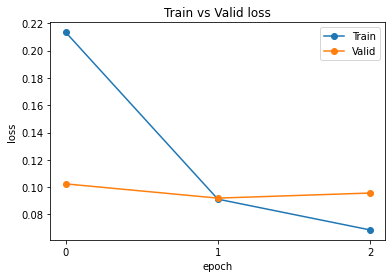

In [20]:
plot_history(history=np.array(mod.history_loss),
             history_val=np.array(mod.history_loss_val),
             ylabel='loss')

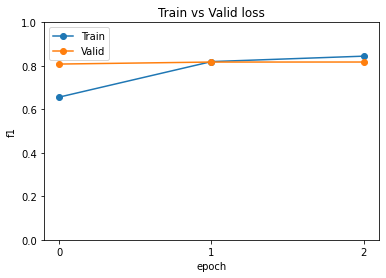

In [21]:
plot_history(history=np.array(mod.history_f1),
             history_val=np.array(mod.history_f1_val),
             ylabel='f1')

In [22]:
torch.save(model.state_dict(), "nbme.pth")